In [13]:
# Miscellaneous
from functools import partial 
from ticktack import load_presaved_model

# Hamiltonian monte-carlo
from numpyro.infer import NUTS, MCMC

import jax.numpy as np
import jax.scipy as sc
import jax.random as random
import matplotlib.pyplot as plt
from jax import jit, jacrev, jacfwd, vmap, grad

In [14]:
cbm = load_presaved_model("Guttler14", production_rate_units="atoms/cm^2/s")
cbm.compile()

In [15]:
@jit
def analytic_solution(parameters, time_out, /, fluxes=cbm._fluxes, 
    contents=cbm._reservoir_content, decay=cbm._decay_matrix):
    """
    This is the analytic solution itself.
    Parameters: 
        
    Returns:
    """
    start_date = parameters[0]
    event_area = parameters[1]

    trop_prod = parameters[2]   
    strat_prod = 1 - trop_prod  # Less degrees of freedom 
    production = np.zeros((11,))
    production = production.at[:2].set([strat_prod, trop_prod])

    weights = np.ones(11, dtype=np.float64)
    weights = weights.at[0].set(parameters[3])  # Less degrees of freedom 
    weights = weights.at[2:].set(parameters[4:])

    # Constructs the transfer matrix 
    c_14_fluxes = fluxes / np.transpose(weights * contents)
    new_c_14_fluxes = np.diag(np.sum(c_14_fluxes, axis=1))
    transfer_matrix = np.transpose(c_14_fluxes) - new_c_14_fluxes - decay
    initial_position = event_area * production

    @vmap
    def vmap_util(t, /, transfer_matrix=transfer_matrix, y0=initial_position, start=start_date):
        return sc.linalg.expm((t - start) * transfer_matrix) @ y0

    impulse_solution = vmap_util(time_out)
    steady_solution = np.zeros((impulse_solution.shape))
    condition = (time_out > start_date).reshape(-1, 1)
    
    return np.where(condition, impulse_solution, steady_solution)

In [16]:
@partial(jit, static_argnums=(0))
def load(filename: str):
    """
    A custom `JAX` file loading protocol designed to be very quick and return a value that is `JAX` transformable. 
    
    Parameters:
        filename: String -> The file address of the data
    Returns:
        DeviceArray -> The data in column major order
    """
    with open(filename) as data:    # Opening the data file
        header = next(data)
        data = np.array([row.strip().split(" ") for row in data], dtype=np.float64)
        return data.T


In [17]:
data = load("miyake12.csv")
data = data.at[1].add(-np.mean(data[1, 1:4]))

In [18]:
@partial(jit, static_argnums=(1, 2))
def loss(parameters, /, analytic_solution=analytic_solution, data=data):
    """
    Computes the log likelihood of a set of parameters in the parameter space
    """
    in_bounds = np.any((parameters[2:] < 0.0) | (parameters[2:] > 1.0)) * -np.inf
    analytic_data = analytic_solution(parameters, data[0])
    chi_sq = np.sum((data[1] - analytic_data[:, 1]) ** 2 / data[2] ** 2)
    return in_bounds + chi_sq

In [41]:
parameters = np.array([774.86, 40.0, 0.3, *[1.0 for _ in range(10)]])

In [42]:
loss(parameters)

DeviceArray(64.37283662, dtype=float64)

In [43]:
gradient(parameters)

DeviceArray([ 1.51676754e+01,  8.52127655e+00,  5.86007122e-01,
             -8.45760664e+01, -8.53860244e+00, -2.39680805e-02,
             -4.15980540e-04, -2.30181002e+01, -1.01958877e-01,
             -8.12767434e+00, -1.14079026e-03, -2.73881942e-04,
             -1.02954883e-07], dtype=float64)

In [44]:
parameters = np.array([774.86, 40.0, 0.7, *[0.9 for _ in range(10)]])

In [45]:
loss(parameters)

DeviceArray(146.35339644, dtype=float64)

In [46]:
gradient(parameters)

DeviceArray([ 9.38469345e+01,  1.77068798e+01,  3.32221671e+02,
             -9.07472562e+01, -1.28120431e+01, -3.58465886e-02,
              1.70830053e-04, -3.50037950e+01, -1.06476246e-01,
             -1.23296296e+01, -1.00720648e-03, -2.41527134e-04,
             -1.15664195e-07], dtype=float64)

In [20]:
gradient = jit(grad(loss))
hessian = jit(jacfwd(jacrev(loss)))

In [21]:
# Running the No U Turn sampling
nuts_kernel = NUTS(potential_fn=loss)
mcmc = MCMC(nuts_kernel, num_warmup=100, num_samples=500, progress_bar=True)
mcmc.run(random.PRNGKey(11), init_params=parameters)

sample: 100%|██████████| 600/600 [00:12<00:00, 48.30it/s, 1 steps of size 1.43e-64. acc. prob=0.00] 


In [22]:
test = mcmc.get_samples()

In [23]:
import seaborn as sns
sns.set()

/home/jordan/anaconda3/envs/kitkat/lib/python3.9/site-packages/seaborn-0.11.2-py3.9.egg/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/jordan/anaconda3/envs/kitkat/lib/python3.9/site-packages/seaborn-0.11.2-py3.9.egg/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/jordan/anaconda3/envs/kitkat/lib/python3.9/site-packages/seaborn-0.11.2-py3.9.egg/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  warnings.warn(msg, UserWarning)
/home/jordan/anaconda3/envs/kitkat/lib/python3.9/site-packages/seaborn-0.11.2-py3.9.egg/seaborn/distributions.py:316: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_sin

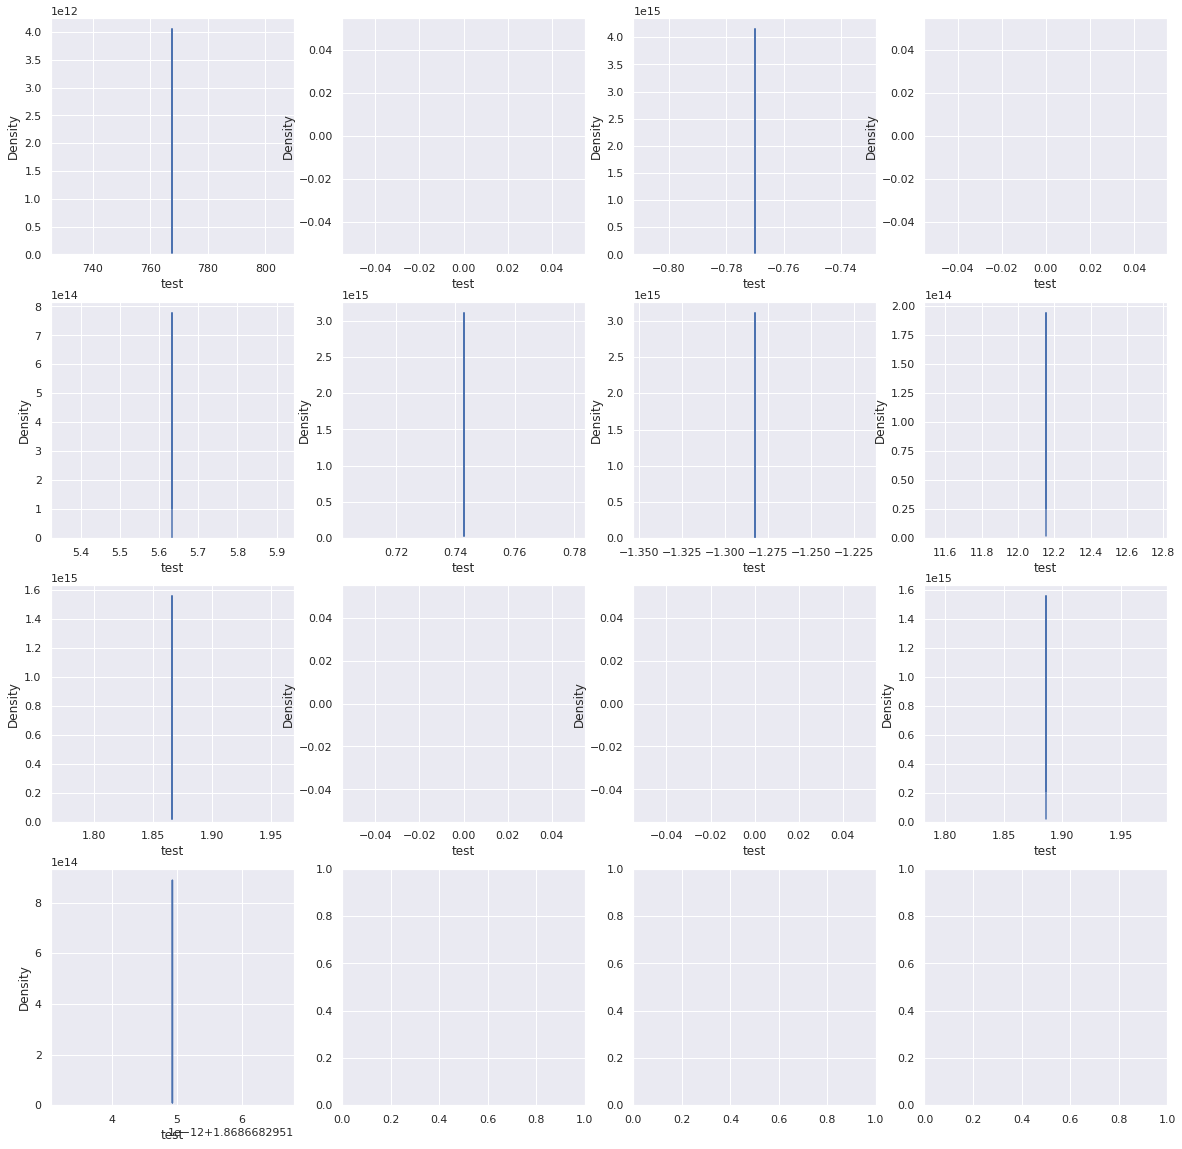

In [24]:
fig, axes = plt.subplots(4, 4, figsize=(20, 20))
for index, variable in enumerate(test.T):
    axis = axes[index // 4][index % 4]
    sns.kdeplot(test.T[index], ax=axis)
    axis.set_xlabel("test")